In [211]:
%load_ext autoreload
%autoreload 2

if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    sys.path.append(str(curr_file_path.parent))
    sys.path.append(os.path.join(str(curr_file_path.parent.parent.parent), 'fixed-point-finder'))

import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import colormaps
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt
from aux_funcs import format_plot, add_pc_axes, format_pc_plot
import torch
import torch.nn as nn
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
from math import sqrt
import gymnasium as gym
from gymnasium import spaces


device = 'cuda' if torch.cuda.is_available() else 'cpu'

envid = 'Random-Walk'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
class RandomWalkIntegrationEnv(gym.Env):
    """
    NeuroGym-style environment for random walk integration task.
    
    Task: Given a 3D input sequence over time T, compute the cumulative sum
    of (input1 - input2) up to each time point. The third input is generally
    zero, but can serve as a gating signal when conditional_integration=True.
    
    Args:
        dt: Time step duration (default: 100ms)
        seq_len: Length of the sequence (default: 50 timesteps)
        batch_size: Number of trials to generate simultaneously (default: 32)
        input_scale: Scale factor for random walk inputs (default: 1.0)
        conditional_integration: If True, only integrate when input3 > 0 (default: False)
        gate_prob: Probability that input3 is high when conditional_integration=True (default: 0.5)
        noise_std: Standard deviation of Gaussian noise added to inputs (default: 0.0)
    """
    
    def __init__(self, seq_len=50, batch_size=32, input_scale=1.0, 
                 conditional_integration=False, gate_prob=0.5, noise_std=0.0,
                 on_circle=False, window=None):
        super().__init__()
        
        # Environment parameters
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.input_scale = input_scale
        self.conditional_integration = conditional_integration
        self.gate_prob = gate_prob
        self.noise_std = noise_std
        self.on_circle = on_circle
        self.window = window
        
        # Gym spaces (note: these are per-trial, batching handled separately)
        # Observation: 3D input at current timestep + time info
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32
        )  # [input1, input2, input3, time_progress]
        
        # Action space: continuous output (the integrated value)
        self.action_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32
        )
        
        # Internal state
        self.reset()
    
    def reset(self):
        """Reset the environment and generate a new batch of sequences."""
        # Generate random walk inputs for all trials in batch
        input1 = np.random.rand(self.batch_size, self.seq_len) * self.input_scale
        input2 = np.random.rand(self.batch_size, self.seq_len) * self.input_scale
        
        # Third input: mostly zero, but can be gating signal
        input3 = np.zeros((self.batch_size, self.seq_len))
        
        if self.conditional_integration:
            # Generate gating signal for each trial
            for batch_idx in range(self.batch_size):
                # Create random segments where gating is active
                for _ in range(np.random.poisson(2)):  # Average 2 segments per trial
                    start = np.random.randint(0, self.seq_len)
                    length = np.random.randint(5, 15)  # 5-15 timestep segments
                    end = min(start + length, self.seq_len)
                    input3[batch_idx, start:end] = 1.0
        
        # Add noise if specified
        if self.noise_std > 0:
            input1 += np.random.normal(0, self.noise_std, (self.batch_size, self.seq_len))
            input2 += np.random.normal(0, self.noise_std, (self.batch_size, self.seq_len))
            input3 += np.random.normal(0, self.noise_std, (self.batch_size, self.seq_len))
        
        # Store the full batch of sequences: Shape (T, batch_size, 3)
        self.inputs = np.stack([input1, input2, input3], axis=-1).transpose(1, 0, 2)
        
        # Compute target outputs for all trials
        self.targets = self._compute_targets()
        
        # Reset time step
        self.current_step = 0
        
        # Return first observation (batched)
        return self._get_observation()
    
    def _compute_targets(self):
        """Compute the target outputs for all sequences in the batch."""
        targets = np.zeros((self.seq_len, self.batch_size))
        
        for batch_idx in range(self.batch_size):
            cumsum = 0.0
            for t in range(self.seq_len):
                if self.window is not None:
                    window = self.window
                    w_start = np.maximum(t+window[0], 0)
                    w_end = np.maximum(t+window[1], 0)
                    cumsum = np.sum(self.inputs[w_start:w_end, batch_idx, 0] - self.inputs[w_start:w_end, batch_idx, 1], axis=0)
                else:
                    if self.conditional_integration:
                        # Only integrate when input3 > 0.5
                        if self.inputs[t, batch_idx, 2] < 0.5:
                            cumsum += self.inputs[t, batch_idx, 0] - self.inputs[t, batch_idx, 1]
                    else:
                        # Always integrate
                        cumsum += self.inputs[t, batch_idx, 0] - self.inputs[t, batch_idx, 1]

                if self.on_circle:
                    targets[t, batch_idx] = cumsum % (2 * np.pi)
                else:
                    targets[t, batch_idx] = cumsum
                    
        return targets
    
    def _get_observation(self):
        """Get the current observation for all trials in batch."""
        if self.current_step >= self.seq_len:
            # Episode is done, return zeros
            return np.zeros((self.batch_size, 4), dtype=np.float32)
        
        # Current inputs + time progress for all trials
        obs = np.zeros((self.batch_size, 4), dtype=np.float32)
        obs[:, 0] = self.inputs[self.current_step, :, 0]  # input1
        obs[:, 1] = self.inputs[self.current_step, :, 1]  # input2
        obs[:, 2] = self.inputs[self.current_step, :, 2]  # input3 (gate)
        obs[:, 3] = self.current_step / self.seq_len      # time progress [0, 1]
        
        return obs
    
    def step(self, action):
        """Take a step in the environment for all trials in batch."""
        if self.current_step >= self.seq_len:
            # Episode already done
            return self._get_observation(), np.zeros(self.batch_size), True, {}
        
        # Get targets for current timestep (all trials)
        targets = self.targets[self.current_step, :]
        
        # Handle action format - ensure it's (batch_size,) shape
        if hasattr(action, 'shape'):
            if action.shape == (self.batch_size, 1):
                predicted = action[:, 0]
            elif action.shape == (self.batch_size,):
                predicted = action
            else:
                predicted = np.array(action).flatten()[:self.batch_size]
        else:
            predicted = np.full(self.batch_size, float(action))
        
        # Compute rewards (negative squared error for each trial)
        rewards = -((predicted - targets) ** 2)
        
        # Move to next timestep
        self.current_step += 1
        done = (self.current_step >= self.seq_len)
        
        # Prepare info dict with useful information
        info = {
            'targets': targets.copy(),
            'predicted': predicted.copy(),
            'errors': np.abs(predicted - targets),
            'timestep': self.current_step - 1,
            'inputs': self.inputs[self.current_step - 1, :, :].copy() if self.current_step > 0 else None
        }
        
        return self._get_observation(), rewards, done, info
    
    def get_full_sequence(self):
        """Return the full input sequences and targets for supervised learning."""
        return {
            'inputs': self.inputs.copy(),      # Shape: (T, batch_size, 3)
            'targets': self.targets.copy(),    # Shape: (T, batch_size)
            'seq_len': self.seq_len,
            'batch_size': self.batch_size
        }
    
    def render(self, mode='human', trial_idx=0):
        """Render the current state for a specific trial (optional)."""
        if mode == 'human':
            print(f"Step {self.current_step}/{self.seq_len} (Trial {trial_idx})")
            if self.current_step > 0 and trial_idx < self.batch_size:
                curr_inputs = self.inputs[self.current_step-1, trial_idx, :]
                curr_target = self.targets[self.current_step-1, trial_idx]
                print(f"Inputs: [{curr_inputs[0]:.3f}, {curr_inputs[1]:.3f}, {curr_inputs[2]:.3f}]")
                print(f"Target: {curr_target:.3f}")


# Example usage and testing
if __name__ == "__main__":
    # Test basic integration with batch
    env = RandomWalkIntegrationEnv(seq_len=15, batch_size=3, conditional_integration=False, window=(-10, -5))
    obs = env.reset()
    dataset = env.get_full_sequence()
    inputs, labels = dataset['inputs'], dataset['targets']

    sums = np.cumsum(inputs[..., 0] - inputs[..., 1], axis=0)

    print('MSE between summed input diff and labels:', np.sum(np.square(sums[:-1] - labels[1:])))

    print("Input sequence:", inputs[:, 0, :])  # First trial
    print("Expected output:", labels)      # First 2 targets
    print("Actual sum:", np.cumsum(inputs[..., 0] - inputs[... ,1], axis=0))

MSE between summed input diff and labels: 35.27264480640854
Input sequence: [[0.18312492 0.49433685 0.        ]
 [0.89800929 0.74905348 0.        ]
 [0.88929102 0.67657172 0.        ]
 [0.15222042 0.74422495 0.        ]
 [0.41136409 0.60655005 0.        ]
 [0.43010035 0.5881622  0.        ]
 [0.73378787 0.52778763 0.        ]
 [0.98594064 0.20217561 0.        ]
 [0.75569428 0.09874356 0.        ]
 [0.23550501 0.97929926 0.        ]
 [0.38299197 0.40537319 0.        ]
 [0.68148463 0.97340021 0.        ]
 [0.60557387 0.48601945 0.        ]
 [0.75163906 0.74558922 0.        ]
 [0.97101084 0.67443612 0.        ]]
Expected output: [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-0.31121193 -0.47400362 -0.12658651]
 [-0.16225612 -1.09782128 -0.08924999]
 [ 0.05046318 -0.92522968 -0.01578618]
 [-0.54154135 -

In [214]:
def get_modelpath(envid):
    # Make a local file directories
    path = Path('.') / 'files'
    os.makedirs(path, exist_ok=True)
    path = path / envid
    os.makedirs(path, exist_ok=True)
    return path

In [215]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, unit_noise_std=0):
        super(Net, self).__init__()
        self.rnn = nn.RNNCell(input_size, hidden_size, nonlinearity='tanh')
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.unit_noise_std =  unit_noise_std

    def forward(self, x):
        batch_size = x.shape[1]
        seq_len = x.shape[0]
        
        h = torch.zeros(batch_size, self.hidden_size)
        all_h = []
        x_out = []

        for t in range(seq_len):
            h = self.rnn(x[t, ...], h)
        
            # Add noise to hidden state after each step
            noise = torch.normal(torch.zeros(batch_size, self.hidden_size)) * self.unit_noise_std / sqrt(self.hidden_size)  # adjust std as needed
            h = h + noise

            all_h.append(h.unsqueeze(0))
            x_out.append(self.linear(h).unsqueeze(0))
        
        # Final output shape: (seq_len, batch_size, hidden_size)
        all_h = torch.cat(all_h, dim=0)
        x_out = torch.cat(x_out, dim=0)
        
        return x_out, all_h

In [216]:
def ortho_mat(size):
    # Andrew Saxe init
    q, r = torch.linalg.qr(torch.randn(*size))
    d = torch.diag(r)
    q *= d.sign()
    return q

(300, 300)


C:\Users\david.bell\AppData\Local\Temp\ipykernel_720\62298052.py:62: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  w_hh[i+chain_width:i+2*chain_width, i:i+chain_width] = np.sqrt(2) * ortho_mat((chain_width, chain_width))


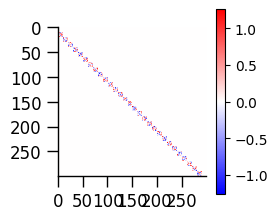

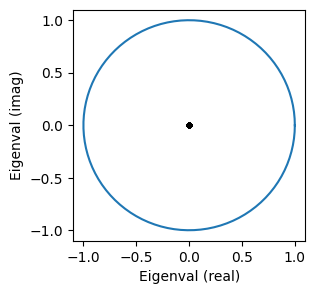

Training task  Random-Walk
200 loss: 5.22429
400 loss: 4.77595
600 loss: 4.32167
800 loss: 3.93156
1000 loss: 3.48790
1200 loss: 3.20756
1400 loss: 2.99784
1600 loss: 2.55554
1800 loss: 2.22500
2000 loss: 2.10139
2200 loss: 1.88309
2400 loss: 1.70287
2600 loss: 1.64268
2800 loss: 1.43245
3000 loss: 1.42325
3200 loss: 1.27016
3400 loss: 1.27935
3600 loss: 1.14468
3800 loss: 1.10123
4000 loss: 1.06408
4200 loss: 0.97084
4400 loss: 0.98101
4600 loss: 0.94200
4800 loss: 0.95064
5000 loss: 0.95849
5200 loss: 0.91027
5400 loss: 0.89750
5600 loss: 0.79064
5800 loss: 0.87107
6000 loss: 0.88289
Finished Training
(300, 300)


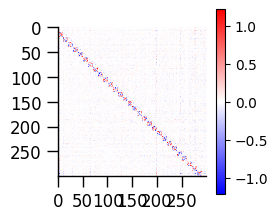

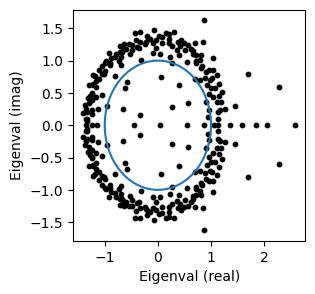

In [217]:
"""Supervised training networks.

Save network in a path determined by environment ID.

Args:
    envid: str, environment ID.
"""
modelpath = get_modelpath(envid)
config = {
    'hidden_size': 10 * 30, # 3 * seq_len
    'lr': 1e-3,
    'batch_size': 100,
    'seq_len': 30,
    'envid': envid,
}



# Save config
with open(modelpath / 'config.json', 'w') as f:
    json.dump(config, f)


env = RandomWalkIntegrationEnv(
    seq_len=config['seq_len'],
    batch_size=config['batch_size'],
    conditional_integration=False,
    # window=(-10, -5),
    on_circle=True,
)
obs = env.reset()

act_size = 1
# Train network
net = Net(
    input_size=3,
    hidden_size=config['hidden_size'],
    output_size=act_size,
    unit_noise_std=0.2,
)

hidden_size = config['hidden_size']
input_size = 3
chain_width = 10

# Andrew Saxe init
# w_hh = ortho_mat((hidden_size, hidden_size)).numpy() * 0.1
# w_ih = np.random.normal(size=(hidden_size, input_size), scale=2/np.sqrt(input_size))

# Rank 1 init
# v = np.ones((hidden_size))
# w_hh = np.outer(v, v) * np.sqrt(2) / hidden_size

# net.rnn.weight_hh.data = torch.from_numpy(w_hh).float().to(device)
# net.rnn.bias_hh.data = torch.zeros((hidden_size)).float().to(device)
# net.rnn.weight_ih.data = torch.from_numpy(w_ih).float().to(device)
# net.rnn.bias_ih.data = torch.zeros((hidden_size)).float().to(device)

# # Seq init
w_hh = np.zeros((hidden_size, hidden_size))
for i in range(0, hidden_size - chain_width, chain_width):
    w_hh[i+chain_width:i+2*chain_width, i:i+chain_width] = np.sqrt(2) * ortho_mat((chain_width, chain_width))

w_ih = np.zeros((hidden_size, input_size))
w_ih[:chain_width, :] = np.random.rand(chain_width, input_size) * 1/np.sqrt(input_size)

    
net.rnn.weight_hh.data = torch.from_numpy(w_hh).float()
net.rnn.bias_hh.data = torch.zeros((hidden_size)).float()
net.rnn.weight_ih.data = torch.from_numpy(w_ih).float()
net.rnn.bias_ih.data = torch.zeros((hidden_size)).float()

# net.rnn.weight_hh.requires_grad = False

w_hh = net.rnn.weight_hh.clone().detach().cpu().numpy()
print(w_hh.shape)

scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale))
m = np.abs(w_hh).max()
cbar = axs.matshow(w_hh, cmap='bwr', vmin=-m, vmax=m)
fig.colorbar(cbar)
format_plot(axs)
plt.show()

scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
res = np.linalg.eig(w_hh)
eigen_vals = res.eigenvalues
axs.scatter(eigen_vals.real, eigen_vals.imag, s=10, c='black')
x = np.linspace(0, 2 * np.pi, 100)
axs.plot(np.cos(x), np.sin(x))
axs.set_xlabel('Eigenval (real)')
axs.set_ylabel('Eigenval (imag)')
plt.show()

net = net.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'])

print('Training task ', envid)

running_loss = 0.0
training_iters = int(6e3)

for i in range(training_iters):
    # if i == 3000:
    #     env = RandomWalkIntegrationEnv(
    #         seq_len=config['seq_len'],
    #         batch_size=config['batch_size'],
    #         on_circle=True,
    #     )
    
    env.reset()
    dataset = env.get_full_sequence()
    inputs_raw, labels_raw = dataset['inputs'], dataset['targets']
    
    inputs = torch.from_numpy(inputs_raw).type(torch.float).to(device)
    labels = torch.from_numpy(labels_raw.flatten()).type(torch.float).to(device)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    
    outputs, _ = net(inputs)

    loss = criterion(outputs.flatten(), labels)
    loss.backward()

    # # zero out non-sequential part of gradient
    # for i in range(0, hidden_size - chain_width, chain_width):
    #     net.rnn.weight_hh.grad[:i+chain_width, i:i+chain_width] = 0
    #     net.rnn.weight_hh.grad[i+2*chain_width:, i:i+chain_width] = 0

    # print("Gradient norm:", net.rnn.weight_hh.grad.norm().item())
    # print("Weight change:", (net.rnn.weight_hh.data - w_hh).norm().item())

    optimizer.step()

    # print statistics
    running_loss += loss.item()
    save_freq = 200
    if training_iters == 1 or i % save_freq == (save_freq - 1):
        print('{:d} loss: {:0.5f}'.format(i + 1, running_loss / save_freq))
        running_loss = 0.0
        torch.save(net.state_dict(), modelpath / 'net.pth')

        # print(outputs[1, 0, :])

print('Finished Training')

w_hh = net.rnn.weight_hh.clone().detach().cpu().numpy()
print(w_hh.shape)

scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale))
m = np.abs(w_hh).max()
cbar = axs.matshow(w_hh, cmap='bwr', vmin=-m, vmax=m)
fig.colorbar(cbar)
format_plot(axs)
plt.show()

scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
res = np.linalg.eig(w_hh)
eigen_vals = res.eigenvalues
axs.scatter(eigen_vals.real, eigen_vals.imag, s=10, c='black')
x = np.linspace(0, 2 * np.pi, 100)
axs.plot(np.cos(x), np.sin(x))
axs.set_xlabel('Eigenval (real)')
axs.set_ylabel('Eigenval (imag)')
plt.show()

C:\Users\david.bell\AppData\Local\Temp\ipykernel_720\1874388281.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  m = np.abs(inputs_for_example).max()
C:\Users\david.bell\AppData\Local\Temp\ipykernel_720\1874388281.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  m = np.abs(outputs_for_example).max()
C:\Users\david.bell\AppData\Local\Temp\ipykernel_720\1874388281.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  m = np.abs(labels_for_example).max()


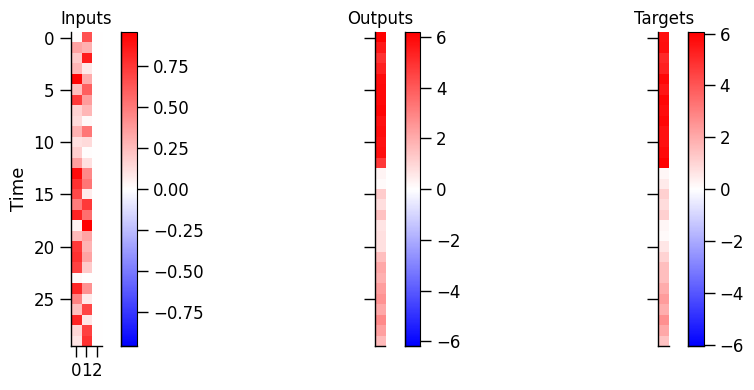

In [218]:
batch_idx = 2

cbar_axs = []

scale = 5
fig, axs = plt.subplots(1, 3, figsize=(2 * scale, 0.8 * scale), sharey=True)
axs[0].set_ylabel('Time')
inputs_for_example = inputs.cpu()[:, batch_idx, :]
m = np.abs(inputs_for_example).max()
cbar = axs[0].matshow(inputs_for_example, vmin=-m, vmax=m, cmap='bwr')
cbar_ax = fig.colorbar(cbar, ax=axs[0])
cbar_axs.append(cbar_ax.ax)
axs[0].set_title('Inputs')

outputs_for_example = outputs.detach().cpu()[:, batch_idx, :]
m = np.abs(outputs_for_example).max()
cbar = axs[1].matshow(outputs_for_example, vmin=-m, vmax=m, cmap='bwr')
cbar_ax = fig.colorbar(cbar, ax=axs[1])
cbar_axs.append(cbar_ax.ax)
axs[1].set_xticks([])
axs[1].set_title('Outputs')

labels_for_example = labels.detach().cpu().view(config['seq_len'], config['batch_size'])[:, batch_idx][:, None]
m = np.abs(labels_for_example).max()
cbar = axs[2].matshow(labels_for_example, vmin=-m, vmax=m, cmap='bwr')
cbar_ax = fig.colorbar(cbar, ax=axs[2])
cbar_axs.append(cbar_ax.ax)
axs[2].set_xticks([])
axs[2].set_title('Targets')

format_plot(axs)
format_plot(cbar_axs)
fig.tight_layout()

In [219]:
def infer_test_timing(env):
    """Infer timing of environment for testing."""
    timing = {}
    for period in env.timing.keys():
        period_times = [env.sample_time(period) for _ in range(100)]
        timing[period] = np.median(period_times)
    return timing

In [220]:
"""Run trained networks for analysis.

Args:
    envid: str, Environment ID

Returns:
    activity: a list of activity matrices, each matrix has shape (
    N_time, N_neuron)
    info: pandas dataframe, each row is information of a trial
    config: dict of network, training configurations
"""
# Load model config
modelpath = get_modelpath(envid)
with open(modelpath / 'config.json') as f:
    config = json.load(f)
    print(config)


# Load model
with torch.no_grad():
    net = Net(
        input_size=3,
        hidden_size=config['hidden_size'],
        output_size=act_size,
    )

    net.load_state_dict(torch.load(modelpath / 'net.pth', map_location=device))

    num_trial = 100
    obs = []

    env = RandomWalkIntegrationEnv(
        seq_len=config['seq_len'],
        batch_size=config['batch_size'],
        # conditional_integration=True,
        # window=(-10, -5)
        on_circle=True,
    )
    obs = env.reset()

    dataset = env.get_full_sequence()
    inputs_raw, labels_raw = dataset['inputs'], dataset['targets']
    
    inputs = torch.from_numpy(inputs_raw).type(torch.float).to(device)
    labels = torch.from_numpy(labels_raw.flatten()).type(torch.float).to(device)
    
    outputs, hidden = net(inputs)
    activity = hidden.cpu()

    # Log hidden activity

    print(np.square((outputs.flatten() - labels)).mean())

{'hidden_size': 300, 'lr': 0.001, 'batch_size': 100, 'seq_len': 30, 'envid': 'Random-Walk'}
tensor(0.9925)


C:\Users\david.bell\AppData\Local\Temp\ipykernel_720\2586737871.py:52: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(np.square((outputs.flatten() - labels)).mean())


C:\Users\david.bell\AppData\Local\Temp\ipykernel_720\1365463767.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  m = np.abs(act_for_trial).max()


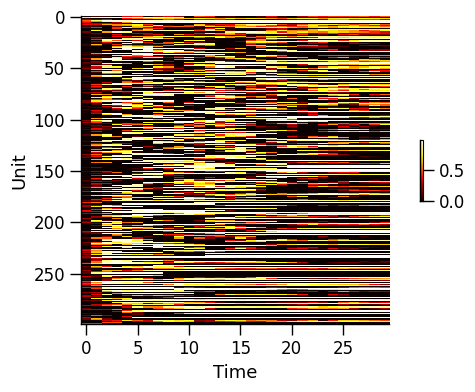

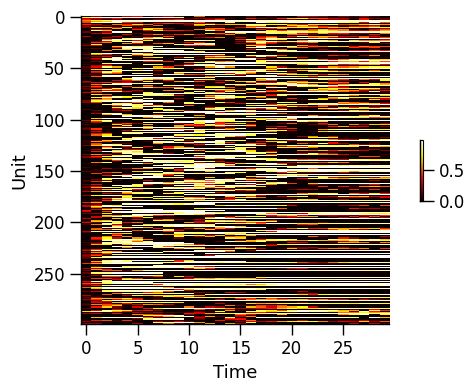

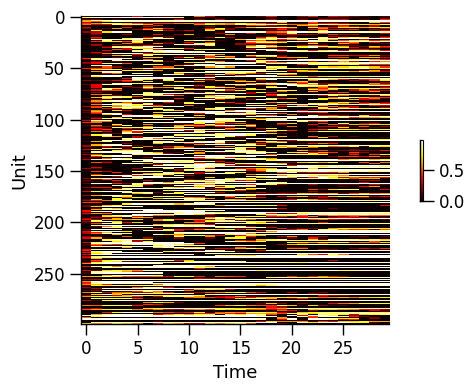

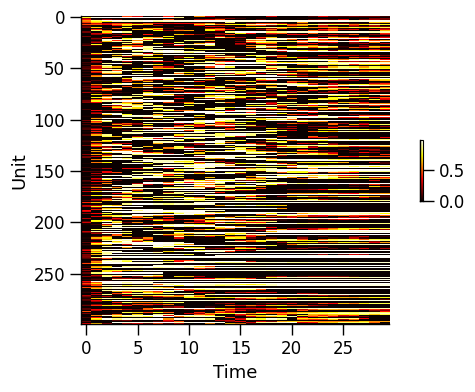

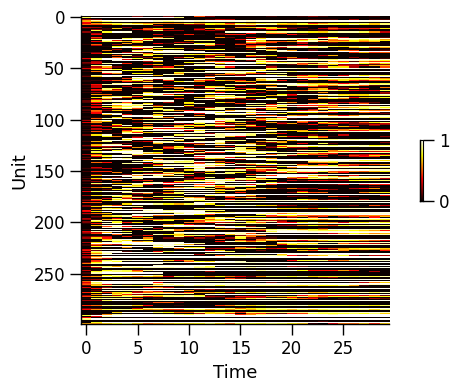

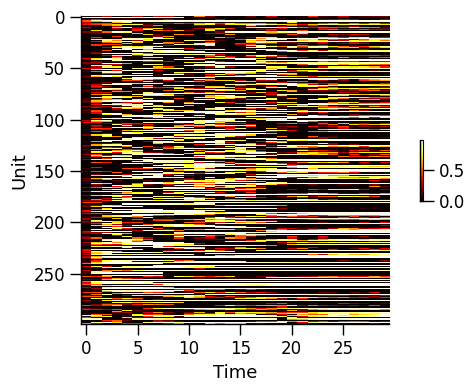

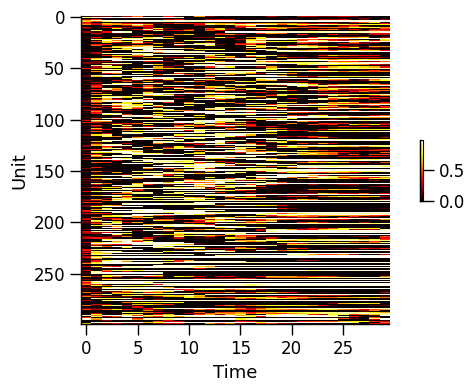

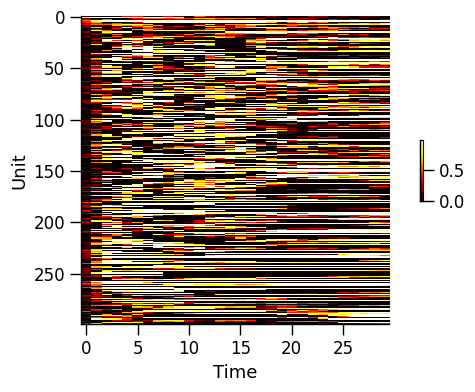

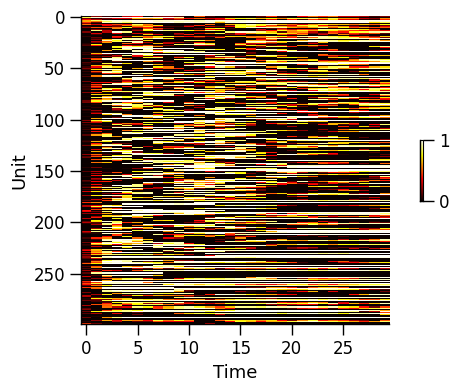

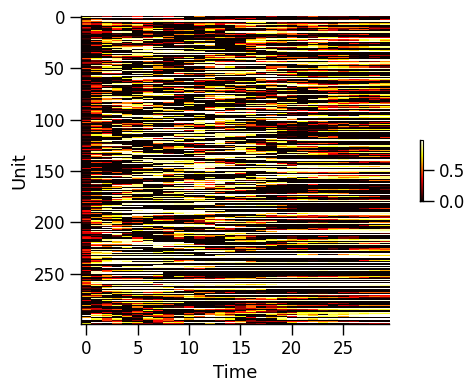

In [221]:
cbar_axs = []

for i in range(10):
    scale = 4
    fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 1 * scale))
    act_for_trial = activity[:, i, :].T
    m = np.abs(act_for_trial).max()
    cbar = axs.matshow(act_for_trial, aspect=0.1, vmin=0, vmax=m, cmap='hot')
    axs.set_xlabel('Time')
    axs.set_ylabel('Unit')
    cbar_ax = fig.colorbar(cbar, ax=axs, shrink=0.2) 
    cbar_axs.append(cbar_ax.ax)
    format_plot(axs)

format_plot(cbar_axs)


In [222]:
def get_conditions(info):
    """Get a list of task conditions to plot."""
    conditions = info.columns
    # This condition's unique value should be less than 5
    new_conditions = list()
    for c in conditions:
        try:
            n_cond = len(pd.unique(info[c]))
            if 1 < n_cond < 5:
                new_conditions.append(c)
        except TypeError:
            pass
        
    return new_conditions

torch.Size([3000, 300])


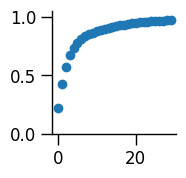

In [223]:
activity_copy = activity.clone()
activity_reshape = np.reshape(activity_copy, (-1, activity_copy.shape[-1]))
print(activity_reshape.shape)
pca = PCA()
pc_activities = pca.fit(activity_reshape)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
# fig.tight_layout()
# format_pc_plot(axs)
scale = 2
fig, axs = plt.subplots(1, 1, figsize=(0.8 * scale, 0.8 * scale))
axs.scatter(np.arange(30), np.cumsum(pca.explained_variance_ratio_[:30]))
axs.set_ylim(0, 1.05)
format_plot(axs)

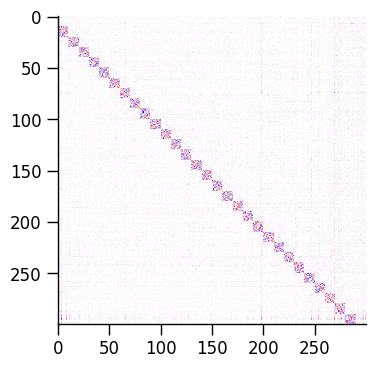

In [225]:
scale = 2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale))
w_hh = net.rnn.weight_hh.detach().cpu().numpy()
m = np.abs(w_hh).max()
axs.matshow(net.rnn.weight_hh.detach().cpu().numpy(), cmap='bwr', vmin=-m, vmax=m)
format_plot(axs)

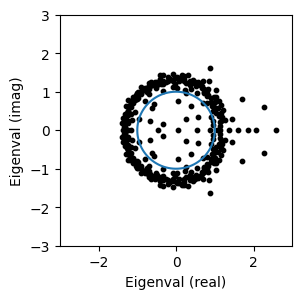

In [226]:
scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
res = np.linalg.eig(w_hh)
eigen_vals = res.eigenvalues
axs.scatter(eigen_vals.real, eigen_vals.imag, s=10, c='black')
x = np.linspace(0, 2 * np.pi, 100)
axs.plot(np.cos(x), np.sin(x))
axs.set_xlabel('Eigenval (real)')
axs.set_ylabel('Eigenval (imag)')
axs.set_xlim(-3, 3)
axs.set_ylim(-3, 3)

plt.show()

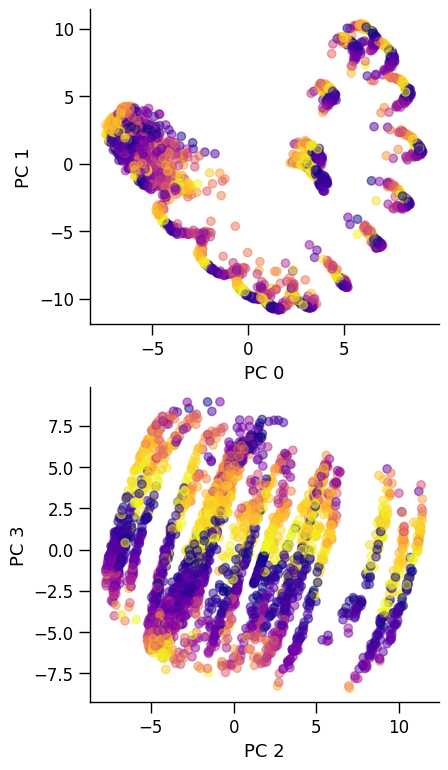

In [227]:
## scale = 1.5
fig, ax = plt.subplots(2, 1, figsize=(3 * scale, 6 * scale), sharex=False, sharey=False)

all_pc_activities = []

for batch_idx in range(activity.shape[1]):
    labels_for_batch = labels.view(config['seq_len'], config['batch_size'])[:, batch_idx]

    # Extract full trajectory over time for this sample and component pair
    pc_activities = pca.transform(activity[:, batch_idx, :])
    all_pc_activities.append(pc_activities)

    for k in np.arange(0, 4, 2):  # Plot trajectories for k and k+1 components
        ax[k//2].scatter(pc_activities[:, k], pc_activities[:, k+1], c=labels_for_batch, alpha=0.5, cmap='plasma')

        ax[k//2].set_xlabel(f'PC {k}')
        ax[k//2].set_ylabel(f'PC {k+1}')
format_plot(ax)

all_pc_activities = np.concatenate(all_pc_activities, axis=0)
# maxes = all_pc_activities.max(axis=0)
# mins = all_pc_activities.min(axis=0)
# ax.set_xlim(1.1 * mins[0], 1.1 * maxes[0])
# ax.set_ylim(1.1 * mins[1], 1.1 * maxes[1])

# ax.set_xticklabels([])
# ax.set_yticklabels([])

plt.show()
None

In [158]:
def detect_timing_and_features(ob):
    fixation_cue = ob[:, 0]
    stim = ob[:, 1:]
    stim_mean = stim.mean(axis=1)

    stim_onsets = np.arange(ob.shape[0])[(stim_mean > 0) & (np.roll(stim_mean, 1) == 0)]
    stim_offsets = np.arange(ob.shape[0])[(stim_mean == 0) & (np.roll(stim_mean, 1) > 0)]

    stim_1 = stim[stim_onsets[0]:stim_offsets[0], :].mean(axis=0)
    stim_2 = stim[stim_onsets[1]:stim_offsets[1], :].mean(axis=0)

    stim_1_loc = np.argmax(stim_1)
    stim_2_loc = np.argmax(stim_2)
    
    return stim_onsets, stim_offsets, stim_1_loc, stim_2_loc

In [259]:
def value_to_hex_color(value, vmin=0, vmax=1, cmap_name='viridis'):
    """
    Maps a value in the range [vmin, vmax] to a hex color using the given matplotlib colormap.

    Parameters:
        value (float): The input value to map.
        vmin (float): The minimum value of the range.
        vmax (float): The maximum value of the range.
        cmap_name (str): Name of the matplotlib colormap to use.

    Returns:
        str: Hex color string (e.g., "#1f77b4").
    """
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    
    # Use new recommended colormap API (Matplotlib 3.7+)
    cmap = colormaps.get_cmap(cmap_name)

    rgba = cmap(norm(value))
    return mcolors.to_hex(rgba)

In [260]:
def plot_dynamics(start, end, color_var, cmap='plasma', max_color_var=1, start_mod=0, end_mod=0):
    scale = 1.5
    fig, ax = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)
    
    all_pc_activities = []
    
    for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
        for i in range(info.shape[0]):
    
            # Extract full trajectory over time for this sample and component pair
            pc_activities = pca.transform(activity[i])
            all_pc_activities.append(pc_activities)
            T = pc_activities.shape[0]
            t = np.arange(len(activity[i]))
    
            ob = obs[i]
            stim_onsets, stim_offsets, stim_1_loc, stim_2_loc = detect_timing_and_features(ob)
    
            task_properties = {
                'stim_1_loc': stim_1_loc,
                'stim_2_loc': stim_2_loc,
                'gt': int(info.iloc[i]['ground_truth']) == 1,
                'stim_onset_1': stim_onsets[0],
                'stim_onset_2': stim_onsets[1],
                'stim_offset_1': stim_offsets[0],
                'stim_offset_2': stim_offsets[1],
            }

            start_ = task_properties[start] if type(start) == str else start
            end_ = task_properties[end] if type(end) == str else end

            if end_ is None:
                period = slice(start_ + start_mod, end_)
            else:
                period = slice(start_ + start_mod, end_ + end_mod)
            
            ax.plot(
                pc_activities[period, k],
                pc_activities[period, k+1],
                color=value_to_hex_color(task_properties[color_var], vmax=max_color_var, cmap_name=cmap),
                alpha=0.5,
                linewidth=0.8
            )
    
            format_plot(ax)
    
    all_pc_activities = np.concatenate(all_pc_activities, axis=0)
    maxes = all_pc_activities.max(axis=0)
    mins = all_pc_activities.min(axis=0)
    ax.set_xlim(1.1 * mins[0], 1.1 * maxes[0])
    ax.set_ylim(1.1 * mins[1], 1.1 * maxes[1])
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_xlabel(f'PC {k}')
    ax.set_ylabel(f'PC {k+1}')
    
    plt.show()

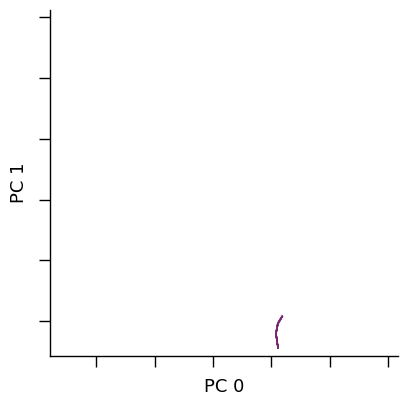

In [261]:
plot_dynamics(
    start=0,
    end='stim_onset_1',
    color_var='gt',
    cmap='Spectral',
    max_color_var=1,
    start_mod=0,
    end_mod=0,
)

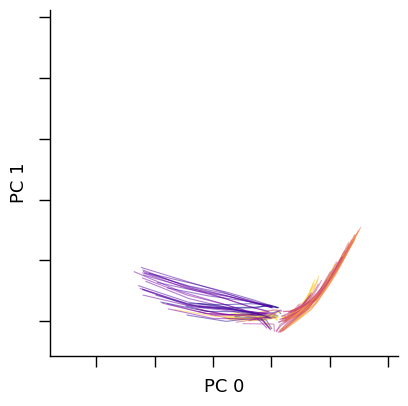

In [262]:
plot_dynamics(
    start='stim_onset_1',
    end='stim_offset_1',
    color_var='stim_1_loc',
    cmap='plasma',
    max_color_var=config['dim_ring'],
    start_mod=0,
    end_mod=0,
)

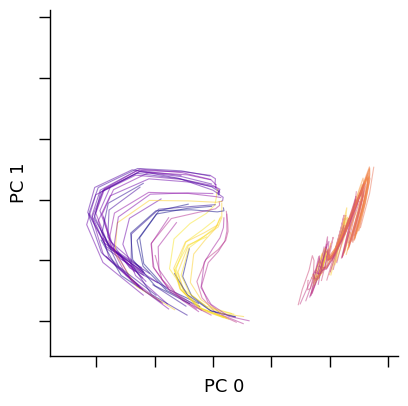

In [263]:
plot_dynamics(
    start='stim_offset_1',
    end='stim_onset_2',
    color_var='stim_1_loc',
    cmap='plasma',
    max_color_var=config['dim_ring'],
    start_mod=-1,
    end_mod=0,
)

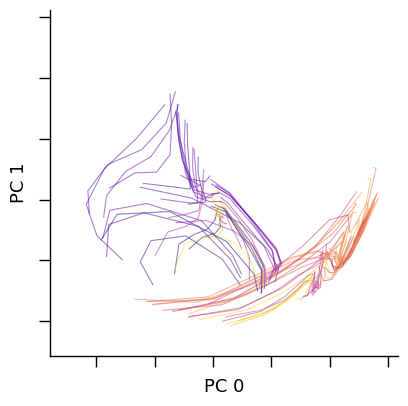

In [264]:
plot_dynamics(
    start='stim_onset_2',
    end='stim_offset_2',
    color_var='stim_1_loc',
    cmap='plasma',
    max_color_var=config['dim_ring'],
    start_mod=-1,
    end_mod=0,
)

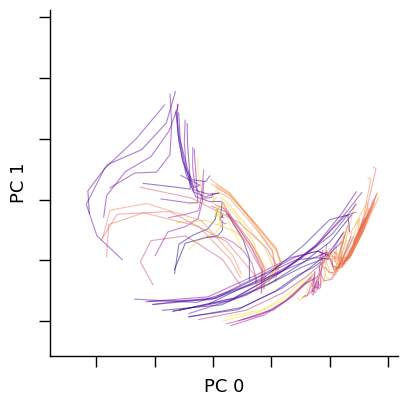

In [265]:
plot_dynamics(
    start='stim_onset_2',
    end='stim_offset_2',
    color_var='stim_2_loc',
    cmap='plasma',
    max_color_var=config['dim_ring'],
    start_mod=-1,
    end_mod=0,
)

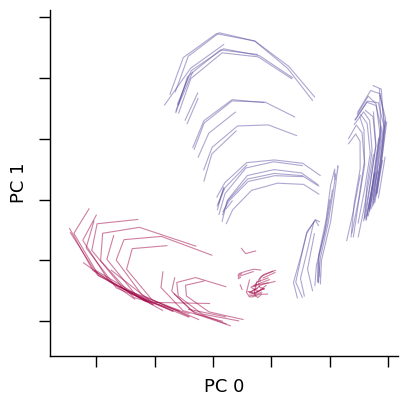

In [266]:
plot_dynamics(
    start='stim_offset_2',
    end=None,
    color_var='gt',
    cmap='Spectral',
    max_color_var=1,
    start_mod=-1,
    end_mod=0,
)

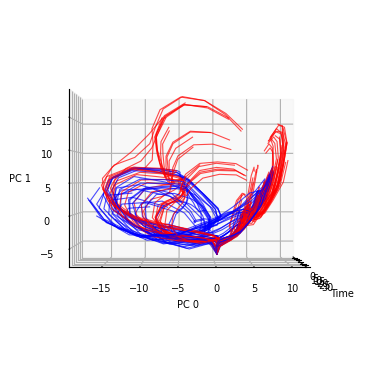

In [267]:
scale = 1.5
fig = plt.figure(figsize=(3 * scale, 3 * scale))
ax = fig.add_subplot(111, projection='3d')

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[1]
        t = np.arange(len(activity[i]))
        x = t
        y = pc_activities[:, k]
        z =  pc_activities[:, k+1]

        ax.plot(x, y, z, color=color, alpha=0.7, linewidth=0.8)

ax.set_ylabel(f'PC {k}')
ax.set_zlabel(f'PC {k+1}')
ax.set_xlabel('Time')
# ax.view_init(elev=30, azim=90) 
# plt.show()
ax.view_init(elev=0, azim=0) 
plt.show()

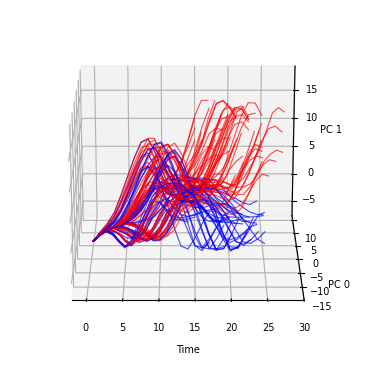

In [268]:
scale = 1.5
fig = plt.figure(figsize=(3 * scale, 3 * scale))
ax = fig.add_subplot(111, projection='3d')

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[1]
        t = np.arange(len(activity[i]))
        x = t
        y = pc_activities[:, k]
        z = pc_activities[:, k+1]

        ax.plot(x, y, z, color=color, alpha=0.7, linewidth=0.8)

ax.set_ylabel(f'PC {k}')
ax.set_zlabel(f'PC {k+1}')
ax.set_xlabel('Time')
# ax.view_init(elev=30, azim=90) 
# plt.show()
ax.view_init(elev=20, azim=-90) 
plt.show()

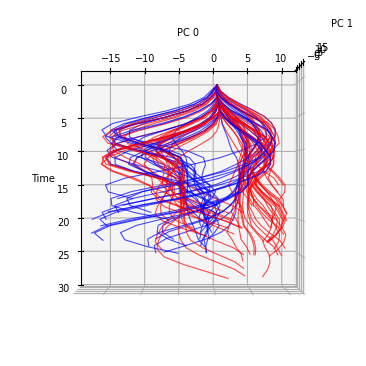

In [269]:
scale = 1.5
fig = plt.figure(figsize=(3 * scale, 3 * scale))
ax = fig.add_subplot(111, projection='3d')

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[1]
        t = np.arange(len(activity[i]))
        x = t
        y = pc_activities[:, k]
        z =  pc_activities[:, k+1]

        ax.plot(x, y, z, color=color, alpha=0.7, linewidth=0.8)

ax.set_ylabel(f'PC {k}')
ax.set_zlabel(f'PC {k+1}')
ax.set_xlabel('Time')
# ax.view_init(elev=30, azim=90) 
# plt.show()
ax.view_init(elev=90, azim=0) 
plt.show()

In [270]:
activity_reshape

fpf_hps = {
		'max_iters': 10000,
		'lr_init': 1e-3,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
        'tol_q': 5e-3,
        # 'tol_unique': 1e-3,
}

net.rnn.batch_first = False
net.single_unit_noise = 0
fpf = FixedPointFinder(net.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, config['dim_ring'] + 1])
samples = np.zeros(activity_reshape.shape[0]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = activity_reshape[samples, :]

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(initial_states, inputs)
print(len(unique_fps))

# for i in range(100):
#     it = initial_states[i, :]
#     print(np.dot(pca.components_[0, :], it), np.dot(pca.components_[1, :], it))

	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 193).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
193


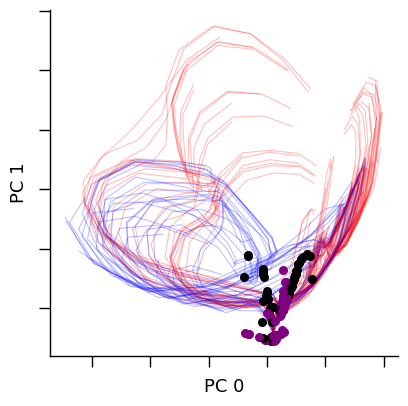

In [271]:
scale = 1.5
fig, ax = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[0]
        t = np.arange(len(activity[i]))

        ax.plot(pc_activities[:, k], pc_activities[:, k+1], color=color, alpha=0.25, linewidth=0.8, zorder=0)

        format_plot(ax)

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) <= 1.0)

        fp_pc = pca.transform(fp.xstar)

        ax.scatter(
            fp_pc[:, k],
            fp_pc[:, k+1],
            color = 'black' if stable else 'purple',
            s=30,
            zorder=1,
        )

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel(f'PC {k}')
ax.set_ylabel(f'PC {k+1}')

plt.show()
None

In [272]:
activity_reshape

fpf_hps = {
		'max_iters': 10000,
		'lr_init': 1e-3,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
        'tol_q': 5e-3,
        # 'tol_unique': 1e-3,
}

net.rnn.batch_first = False
net.single_unit_noise = 0
fpf = FixedPointFinder(net.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, config['dim_ring'] + 1])
inputs[:, 0] = 1
samples = np.zeros(activity_reshape.shape[0]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = activity_reshape[samples, :]

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(initial_states, inputs)
print(len(unique_fps))

# for i in range(100):
#     it = initial_states[i, :]
#     print(np.dot(pca.components_[0, :], it), np.dot(pca.components_[1, :], it))

	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 168).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
168


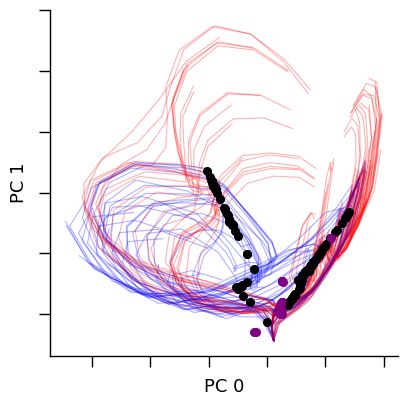

In [273]:
scale = 1.5
fig, ax = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[0]
        t = np.arange(len(activity[i]))

        ax.plot(pc_activities[:, k], pc_activities[:, k+1], color=color, alpha=0.3, linewidth=0.8, zorder=0)

        format_plot(ax)

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) <= 1.0)

        fp_pc = pca.transform(fp.xstar)

        ax.scatter(
            fp_pc[:, k],
            fp_pc[:, k+1],
            color = 'black' if stable else 'purple',
            s=30,
            zorder=1,
        )

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel(f'PC {k}')
ax.set_ylabel(f'PC {k+1}')

plt.show()
None

In [275]:
activity_reshape

fpf_hps = {
		'max_iters': 10000,
		'lr_init': 1e-3,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
        'tol_q': 5e-3,
        # 'tol_unique': 1e-3,
}

net.rnn.batch_first = False
net.single_unit_noise = 0
fpf = FixedPointFinder(net.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, config['dim_ring'] + 1])
inputs[:, 0] = 1
inputs[:, 1:] = np.cos(2 * np.pi * (0 - np.arange(config['dim_ring'])) / config['dim_ring'])
samples = np.zeros(activity_reshape.shape[0]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = activity_reshape[samples, :]

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(initial_states, inputs)
print(len(unique_fps))

	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
200


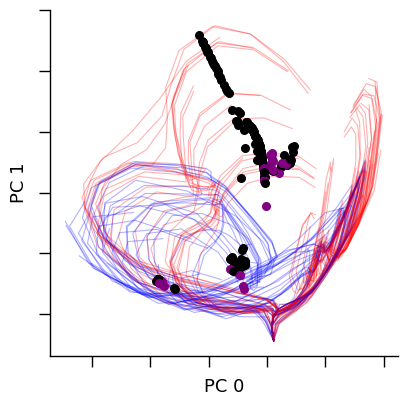

In [276]:
scale = 1.5
fig, ax = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[0]
        t = np.arange(len(activity[i]))

        ax.plot(pc_activities[:, k], pc_activities[:, k+1], color=color, alpha=0.3, linewidth=0.8, zorder=0)

        format_plot(ax)

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) <= 1.0)

        fp_pc = pca.transform(fp.xstar)

        ax.scatter(
            fp_pc[:, k],
            fp_pc[:, k+1],
            color = 'black' if stable else 'purple',
            s=30,
            zorder=1,
        )

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel(f'PC {k}')
ax.set_ylabel(f'PC {k+1}')

plt.show()
None

In [65]:
activity_reshape

fpf_hps = {
		'max_iters': 10000,
		'lr_init': 1e-3,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
        'tol_q': 5e-3,
        # 'tol_unique': 1e-3,
}

net.rnn.batch_first = False
net.single_unit_noise = 0
fpf = FixedPointFinder(net.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, config['dim_ring'] + 1])
inputs[:, 0] = 1
inputs[:, 1:] = np.cos(2 * np.pi * (10 - np.arange(config['dim_ring'])) / config['dim_ring'])
samples = np.zeros(activity_reshape.shape[0]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = activity_reshape[samples, :]

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(initial_states, inputs)
print(len(unique_fps))

	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
200


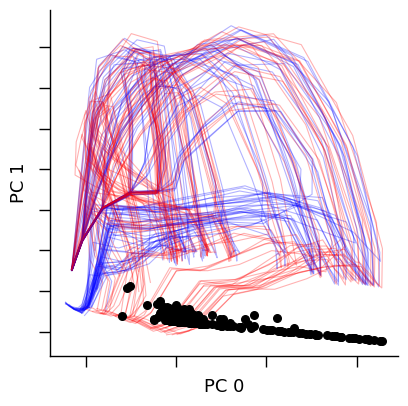

In [67]:
scale = 1.5
fig, ax = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[0]
        t = np.arange(len(activity[i]))

        ax.plot(pc_activities[:, k], pc_activities[:, k+1], color=color, alpha=0.3, linewidth=0.8, zorder=0)

        format_plot(ax)

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) <= 1.0)

        fp_pc = pca.transform(fp.xstar)

        ax.scatter(
            fp_pc[:, k],
            fp_pc[:, k+1],
            color = 'black' if stable else 'purple',
            s=30,
            zorder=1,
        )

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel(f'PC {k}')
ax.set_ylabel(f'PC {k+1}')

plt.show()
None

In [72]:
activity_reshape

fpf_hps = {
		'max_iters': 10000,
		'lr_init': 1e-3,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
        'tol_q': 5e-3,
        # 'tol_unique': 1e-3,
}

net.rnn.batch_first = False
net.single_unit_noise = 0
fpf = FixedPointFinder(net.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, config['dim_ring'] + 1])
inputs[:, 0] = 1
inputs[:, 1:] = np.cos(2 * np.pi * (5 - np.arange(config['dim_ring'])) / config['dim_ring'])
samples = np.zeros(activity_reshape.shape[0]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = activity_reshape[samples, :]

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(initial_states, inputs)
print(len(unique_fps))

	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 169).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
169


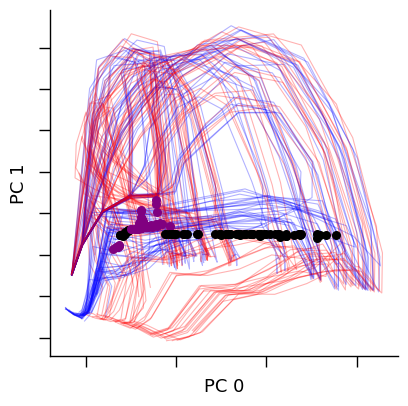

In [73]:
scale = 1.5
fig, ax = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[0]
        t = np.arange(len(activity[i]))

        ax.plot(pc_activities[:, k], pc_activities[:, k+1], color=color, alpha=0.3, linewidth=0.8, zorder=0)

        format_plot(ax)

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) <= 1.0)

        fp_pc = pca.transform(fp.xstar)

        ax.scatter(
            fp_pc[:, k],
            fp_pc[:, k+1],
            color = 'black' if stable else 'purple',
            s=30,
            zorder=1,
        )

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel(f'PC {k}')
ax.set_ylabel(f'PC {k+1}')

plt.show()
None

In [74]:
activity_reshape

fpf_hps = {
		'max_iters': 10000,
		'lr_init': 1e-3,
		'outlier_distance_scale': 10.0,
		'verbose': False, 
		'super_verbose': False,
        'tol_q': 5e-3,
        # 'tol_unique': 1e-3,
}

net.rnn.batch_first = False
net.single_unit_noise = 0
fpf = FixedPointFinder(net.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
n_initial_states = 200
inputs = np.zeros([n_initial_states, config['dim_ring'] + 1])
inputs[:, 0] = 1
inputs[:, 1:] = np.cos(2 * np.pi * (15 - np.arange(config['dim_ring'])) / config['dim_ring'])
samples = np.zeros(activity_reshape.shape[0]).astype(bool)
samples[:n_initial_states] = True
np.random.shuffle(samples)
initial_states = activity_reshape[samples, :]

# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(initial_states, inputs)
print(len(unique_fps))

	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
200


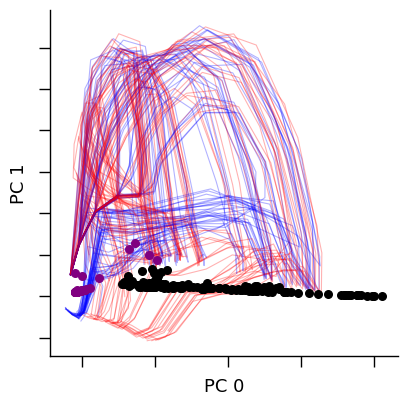

In [75]:
scale = 1.5
fig, ax = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale), sharex=False, sharey=True)

for k in np.arange(0, 2, 2):  # Plot trajectories for k and k+1 components
    for i in range(info.shape[0]):
        color = 'red' if int(info.iloc[i]['ground_truth']) == 1 else 'blue'

        # Extract full trajectory over time for this sample and component pair
        pc_activities = pca.transform(activity[i])
        T = pc_activities.shape[0]
        t = np.arange(len(activity[i]))

        ax.plot(pc_activities[:, k], pc_activities[:, k+1], color=color, alpha=0.3, linewidth=0.8, zorder=0)

        format_plot(ax)

    for i_f in range(unique_fps.xstar.shape[0]):
        fp = unique_fps[i_f]
        
        e_vals = fp.eigval_J_xstar[0]
        stable = np.all(np.abs(e_vals) <= 1.0)

        fp_pc = pca.transform(fp.xstar)

        ax.scatter(
            fp_pc[:, k],
            fp_pc[:, k+1],
            color = 'black' if stable else 'purple',
            s=30,
            zorder=1,
        )

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel(f'PC {k}')
ax.set_ylabel(f'PC {k+1}')

plt.show()
None